In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
df = pd.read_csv("../data/The_Cancer_data_1500_V2.csv")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1500 non-null   int64  
 1   Gender            1500 non-null   int64  
 2   BMI               1500 non-null   float64
 3   Smoking           1500 non-null   int64  
 4   GeneticRisk       1500 non-null   int64  
 5   PhysicalActivity  1500 non-null   float64
 6   AlcoholIntake     1500 non-null   float64
 7   CancerHistory     1500 non-null   int64  
 8   Diagnosis         1500 non-null   int64  
 9   Age_Smoking       1500 non-null   int64  
 10  BMI_Activity      1500 non-null   float64
 11  Genetic_Smoking   1500 non-null   int64  
 12  Alcohol_Smoking   1500 non-null   float64
 13  Obese             1500 non-null   int64  
 14  LowActivity       1500 non-null   int64  
 15  HeavyDrinker      1500 non-null   int64  
 16  Log_Alcohol       1500 non-null   float64


### Feature engineering

In [ ]:

df["Age_Smoking"] = df["Age"] * df["Smoking"]
df["BMI_Activity"] = df["BMI"] * df["PhysicalActivity"]
df["Genetic_Smoking"] = df["GeneticRisk"] * df["Smoking"]
df["Alcohol_Smoking"] = df["AlcoholIntake"] * df["Smoking"]


df["Obese"] = (df["BMI"] >= 30).astype(int)
df["LowActivity"] = (df["PhysicalActivity"] < 2).astype(int)
df["HeavyDrinker"] = (df["AlcoholIntake"] > 3).astype(int)


df["Log_Alcohol"] = np.log1p(df["AlcoholIntake"])
df["Log_Activity"] = np.log1p(df["PhysicalActivity"])


df["Age_squared"] = df["Age"] ** 2
df["BMI_squared"] = df["BMI"] ** 2
df["BMI_per_Age"] = df["BMI"] / df["Age"]

In [ ]:
df.head()

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis,Age_Smoking,...,Genetic_Smoking,Alcohol_Smoking,Obese,LowActivity,HeavyDrinker,Log_Alcohol,Log_Activity,Age_squared,BMI_squared,BMI_per_Age
0,58,1,16.085313,0,1,8.146251,4.148219,1,1,0,...,0,0.0,0,0,1,1.638651,2.213344,3364,258.737305,0.277333
1,71,0,30.828784,0,1,9.361630,3.519683,0,0,0,...,0,0.0,1,0,1,1.508442,2.338110,5041,950.413947,0.434208
2,48,1,38.785084,0,2,5.135179,4.728368,0,1,0,...,0,0.0,1,0,1,1.745431,1.814039,2304,1504.282706,0.808023
3,34,0,30.040296,0,0,9.502792,2.044636,0,0,0,...,0,0.0,1,0,0,1.113381,2.351641,1156,902.419354,0.883538
4,62,1,35.479721,0,0,5.356890,3.309849,0,1,0,...,0,0.0,1,0,1,1.460903,1.849539,3844,1258.810637,0.572254


### Selección final de variables

In [ ]:
df["Age_Smoking"] = df["Age"] * df["Smoking"]
df["BMI_Activity"] = df["BMI"] * df["PhysicalActivity"]
df["Genetic_Smoking"] = df["GeneticRisk"] * df["Smoking"]
df["Alcohol_Smoking"] = df["AlcoholIntake"] * df["Smoking"]

df["Obese"] = (df["BMI"] >= 30).astype(int)
df["LowActivity"] = (df["PhysicalActivity"] < 2).astype(int)
df["HeavyDrinker"] = (df["AlcoholIntake"] > 3).astype(int)

df["Log_Alcohol"] = np.log1p(df["AlcoholIntake"])
df["Log_Activity"] = np.log1p(df["PhysicalActivity"])
df["Age_squared"] = df["Age"] ** 2
df["BMI_squared"] = df["BMI"] ** 2
df["BMI_per_Age"] = df["BMI"] / df["Age"]

target = "Diagnosis"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
cols_to_scale = X_train.select_dtypes(include=[np.number]).columns
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

selector = SelectKBest(score_func=f_classif, k=15)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

mask = selector.get_support()
selected_features = X_train.columns[mask]
print(f"Variables seleccionadas ({len(selected_features)}): {list(selected_features)}")

Variables seleccionadas (15): ['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk', 'AlcoholIntake', 'CancerHistory', 'Age_Smoking', 'Genetic_Smoking', 'Alcohol_Smoking', 'LowActivity', 'HeavyDrinker', 'Log_Alcohol', 'Log_Activity', 'Age_squared']


In [ ]:
print("\nIniciando entrenamiento y optimización del Random Forest...")


rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],      
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10],     
    'min_samples_leaf': [1, 2, 4]        
}

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5,                 
    scoring='recall',    
    n_jobs=-1,            
    verbose=1
)


grid_search.fit(X_train_sel, y_train)

best_rf = grid_search.best_estimator_
print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")


Iniciando entrenamiento y optimización del Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


Exactitud (Accuracy):   0.9167
Sensibilidad (Recall):  0.8793  <-- ¡Crucial en medicina!
Especificidad:          0.9402
Puntuación F1:          0.8908
AUC-ROC:                0.9476


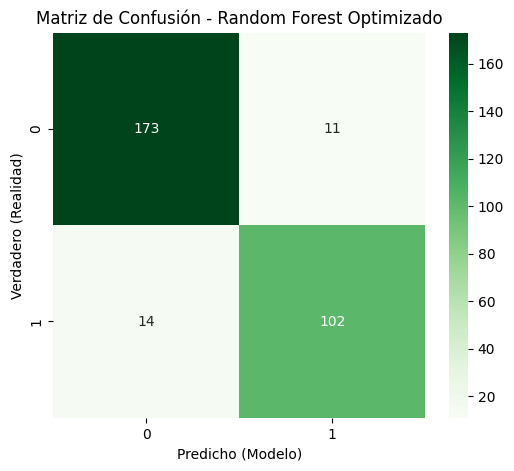

In [ ]:
y_pred = best_rf.predict(X_test_sel)
y_prob = best_rf.predict_proba(X_test_sel)[:, 1]  # Probabilidad para AUC-ROC

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Calcular Especificidad (TN / TN + FP)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
spec = tn / (tn + fp)

print(f"Exactitud (Accuracy):   {acc:.4f}")
print(f"Sensibilidad (Recall):  {rec:.4f} ")
print(f"Especificidad:          {spec:.4f}")
print(f"Puntuación F1:          {f1:.4f}")
print(f"AUC-ROC:                {auc:.4f}")


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Random Forest Optimizado')
plt.ylabel('Verdadero (Realidad)')
plt.xlabel('Predicho (Modelo)')
plt.show()

